In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn import metrics

In [2]:
df=pd.read_csv("student_performance.csv")

In [3]:
df.head(5)

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   StudentID                  10 non-null     int64 
 1   Name                       10 non-null     object
 2   Gender                     10 non-null     object
 3   AttendanceRate             10 non-null     int64 
 4   StudyHoursPerWeek          10 non-null     int64 
 5   PreviousGrade              10 non-null     int64 
 6   ExtracurricularActivities  10 non-null     int64 
 7   ParentalSupport            10 non-null     object
 8   FinalGrade                 10 non-null     int64 
dtypes: int64(6), object(3)
memory usage: 852.0+ bytes


Visualizations

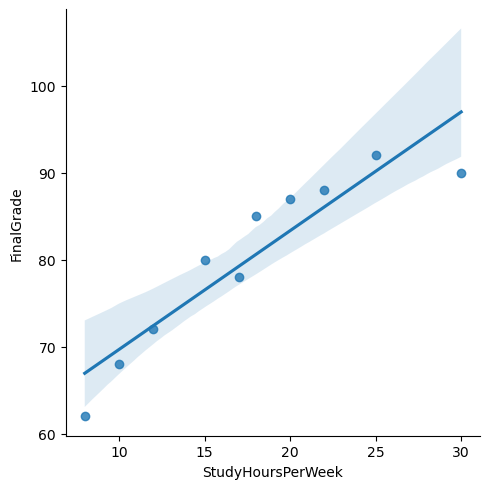

In [6]:
sns.lmplot(x="StudyHoursPerWeek",y="FinalGrade",data=df)

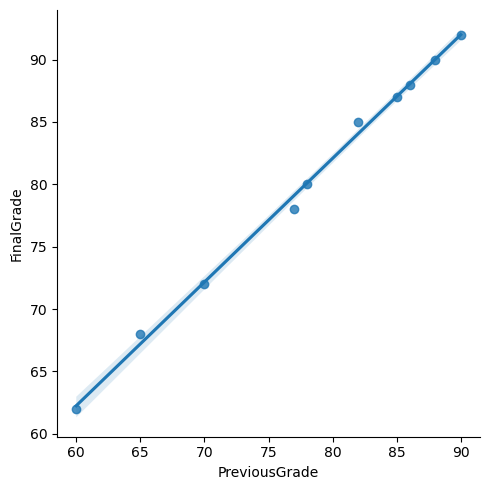

In [7]:
sns.lmplot(x="PreviousGrade",y="FinalGrade",data=df)

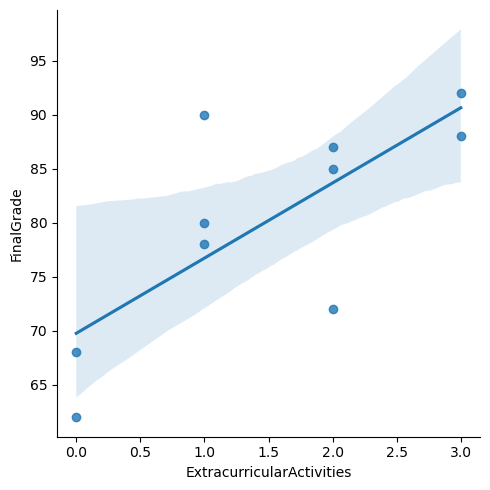

In [8]:
sns.lmplot(x="ExtracurricularActivities",y="FinalGrade",data=df)

<Axes: xlabel='ParentalSupport', ylabel='FinalGrade'>

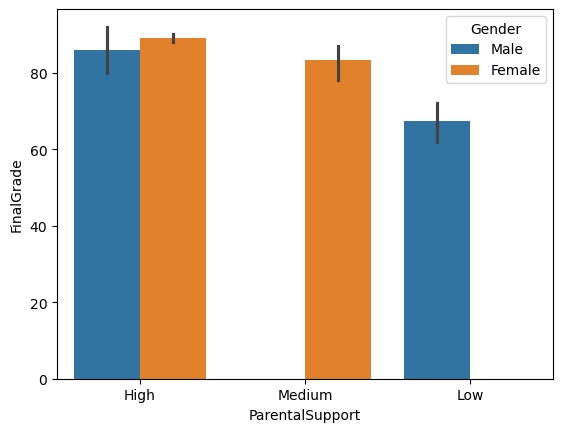

In [9]:
sns.barplot(data=df,x=df["ParentalSupport"],y=df["FinalGrade"],estimator=np.mean,hue=df["Gender"])  

C:\Users\manis\AppData\Local\Temp\ipykernel_20596\1734596450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax = ax, x = df["ParentalSupport"], y = df["FinalGrade"], palette = 'Set1')


<Axes: xlabel='ParentalSupport', ylabel='FinalGrade'>

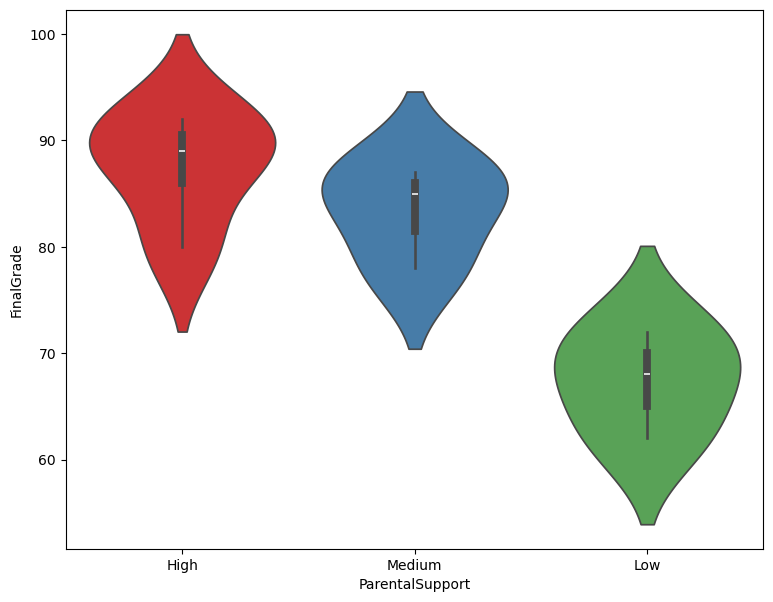

In [10]:
fig, ax = pyplot.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x = df["ParentalSupport"], y = df["FinalGrade"], palette = 'Set1')

In [11]:
df=df.drop(columns=["StudentID","Name"])

In [12]:
df.head()

,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,Male,85,15,78,1,High,80
1,Female,90,20,85,2,Medium,87
2,Male,78,10,65,0,Low,68
3,Male,92,25,90,3,High,92
4,Female,88,18,82,2,Medium,85


Encoding the Data

In [14]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

In [15]:
#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[categorical_columns])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [16]:
X=df_encoded.drop("FinalGrade",axis=1)
y=df_encoded["FinalGrade"]

Investigating the Dataset using Information Gain

In [18]:
info_gain = mutual_info_regression(X, y)

In [19]:
information_gain = pd.DataFrame(info_gain,X.columns)
information_gain.columns = ['Info Gain']
information_gain

,Info Gain
AttendanceRate,0.778968
StudyHoursPerWeek,0.552302
PreviousGrade,0.937302
ExtracurricularActivities,0.122063
Gender_Female,0.276349
Gender_Male,0.276349
ParentalSupport_High,0.184683
ParentalSupport_Low,0.263452
ParentalSupport_Medium,0.000000


Splitting the Dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Deploying Lasso LARS Regression

In [23]:
lars_lasso = LassoLars(alpha=0.05)  # Adjust alpha as needed
lars_lasso.fit(X, y)

LassoLars(alpha=0.05)

In [24]:
coeffecients = pd.DataFrame(lars_lasso.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
AttendanceRate,0.053851
StudyHoursPerWeek,-0.026809
PreviousGrade,0.969183
ExtracurricularActivities,0.000000
Gender_Female,0.000000
Gender_Male,0.000000
ParentalSupport_High,0.000000
ParentalSupport_Low,0.000000
ParentalSupport_Medium,0.000000


Model Performance

In [26]:
predictions_l=lars_lasso.predict(X_test)

In [27]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_l))
print('MSE:', metrics.mean_squared_error(y_test, predictions_l))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_l)))

MAE: 0.07471908474926892
MSE: 0.006912003317206934
RMSE: 0.08313845871320284


**Key Findings**

- Through Information Gain, we see that the **AttendanceRate**, **StudyHoursPerWeek** and **PreviousGrade** has **Higest Contribution** towards the Grade of  Student. 
- Although Information Gain dosent show a Linear Relationship, the Lasso Coeff shows this Relationship.
- High **PreviousGrade** signifies a better performance in the Final Grade (equals to 0.96 increase in Final Marks per previous Grade).
- Holding all other features fixed, a 1 unit increase in **AttendanceRate** equals to 0.05 increase in Marks. 
- 20-25 **StudyHoursPerWeek** proves benificial to a Student and less or more results in a negative development (0.02 decrease in Marks).
- Although Extra Curricular Activities and Parental Support **does not** contribute much to the Grade of a student, but a **Low Parental Support** and  **no Extra Curricular Activity** has a detrimental effect in the Grades of a Student.